In [1]:
# Import all necessary libs and initial setup
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# TASK 1: HSV threshold constants (global change)
hue_threshold = 195
sat_threshold = 42
val_threshold = 228

# TASK 2: area constants (global change)
min_area = 400
overlap_area = 1800

In [2]:
def generate_images(img, otsu_threshold):
    a, b, c = img.shape
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    otsu_out, hsv_out = np.zeros((a, b)), np.zeros((a, b))
    
    for i in range(a):
        for j in range(b):
            if gray_img[i,j] < otsu_threshold: otsu_out.itemset((i,j), 255)
            if hsv_img[i,j][0] > hue_threshold \
                or hsv_img[i,j][1] > sat_threshold \
                or hsv_img[i,j][2] < val_threshold: hsv_out.itemset((i,j), 255)
    
    return otsu_out, hsv_out

In [3]:
# Iterates through each threshold to find desired threshold for
# maximum interclass variance using Otsu's method.
# * references to variance refer to interclass variance
def otsu_method(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    weights = [np.count_nonzero(img.ravel() == i) for i in range(256)]
    means = [i*level for i, level in enumerate(weights)]
    
    max_variance, desired_threshold = 0, 0

    for threshold in range(256):
        variance = calc_variance(weights, means, threshold)
        if variance > max_variance:
            max_variance = variance
            desired_threshold = threshold

    return desired_threshold

def calc_variance(weights, means, threshold):
    # calculate product of background/foreground weights
    b_weights = weights[:threshold]
    f_weights = weights[threshold:]
    if sum(weights) == 0: return 0
    weights_product = (sum(b_weights)*sum(f_weights)) / (sum(weights)**2)
    
    # calculate difference of background/foreground means
    b_means = means[:threshold]
    f_means = means[threshold:]
    if sum(b_means) == 0 or sum(f_means) == 0: return 0
    mean_diff = sum(b_means)/sum(b_weights) - sum(f_means)/sum(f_weights)
    
    # return interclass variance using formula
    return weights_product * mean_diff**2

c1.jpg


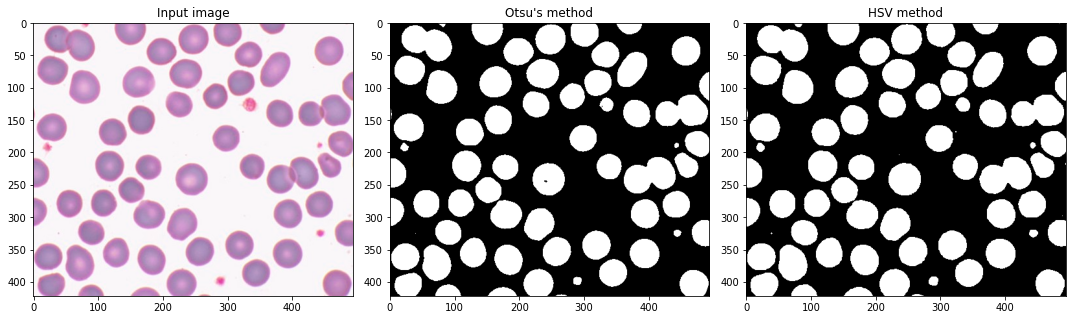

                                       Otsu threshold - 202                  HSV thresholds - hue:195 sat:42 val:228

c2.jpg


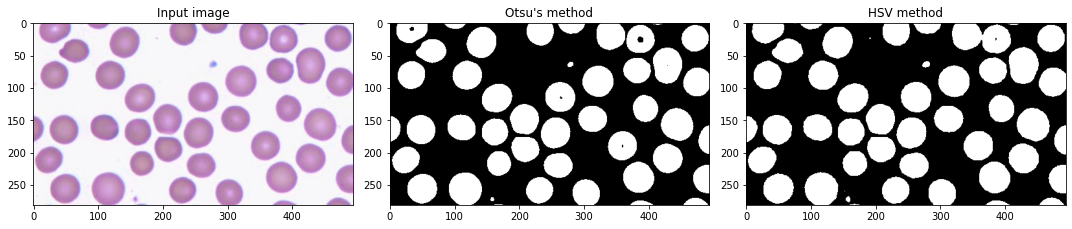

                                       Otsu threshold - 202                  HSV thresholds - hue:195 sat:42 val:228

c3.jpg


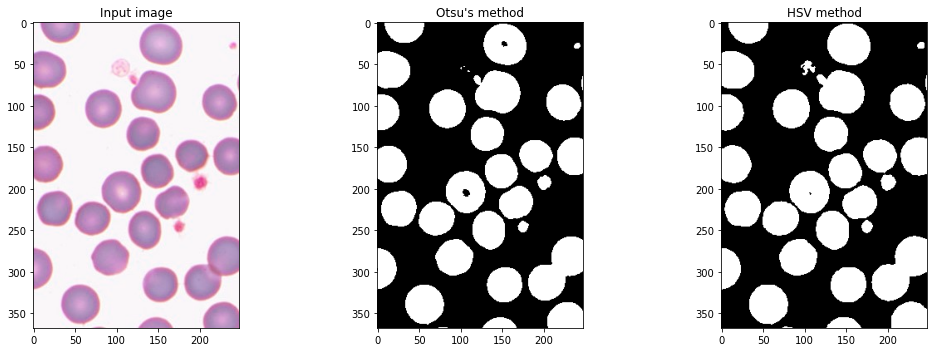

                                       Otsu threshold - 202                  HSV thresholds - hue:195 sat:42 val:228

c4.jpg


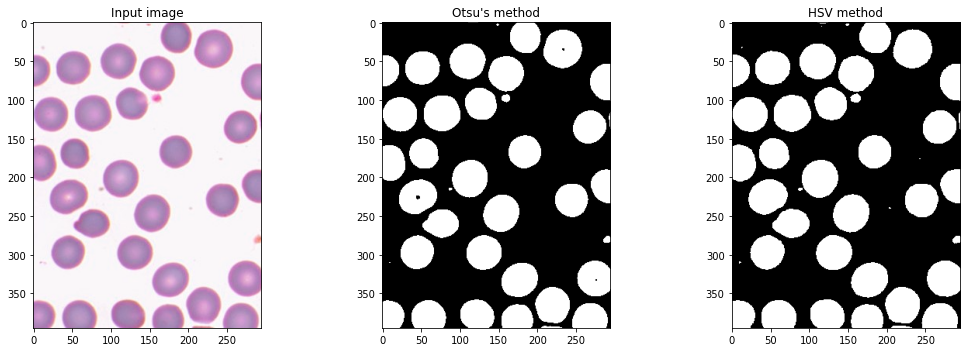

                                       Otsu threshold - 202                  HSV thresholds - hue:195 sat:42 val:228



In [4]:
# Code sequence to run task 1
def task1():
    for filename in os.listdir('in_images'):
        print(filename)

        fig, ax = plt.subplots(1,3, figsize=(15,5))
        
        # show input image
        img = cv2.imread(f'in_images/{filename}')
        ax[0].imshow(img)
        ax[0].set_title('Input image')
        
        otsu_threshold = otsu_method(img)
        otsu_out, hsv_out = generate_images(img, otsu_threshold)
        cv2.imwrite(f'out_images/otsu_{filename}', otsu_out)
        cv2.imwrite(f'out_images/hsv_{filename}', hsv_out)

        # show Otsu's method image
        ax[1].imshow(otsu_out, cmap='gray')
        ax[1].set_title('Otsu\'s method')
        
        # show HSV method image
        ax[2].imshow(hsv_out, cmap='gray')
        ax[2].set_title('HSV method')
        
        plt.tight_layout()
        plt.show()
        print(f'{" "*38} Otsu threshold - {otsu_threshold}', end=' '*18)
        print(f'HSV thresholds - hue:{hue_threshold} sat:{sat_threshold} val:{val_threshold}\n')

task1()

In [5]:
def median_filter(img):
    f_size = 5 # modifiable filter size
    x = np.zeros(img.shape) 
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if i+f_size < img.shape[0] and j+f_size < img.shape[1]:
                subarray = img[i:i+f_size,j:j+f_size]
                x[i, j] = np.median(subarray.ravel())
    return x

In [6]:
def generate_image_and_count_cells(img):
    filtered_img = median_filter(img)
    labelled_img = two_pass_algorithm(filtered_img)
    
    # count unique labels corresponding to cells
    unique, counts = np.unique(labelled_img, return_counts=True)
    d = dict(zip(unique, counts))
    del d[max(d.keys())]

    # filter out any invalid cells
    over_min = len([i for i in d.values() if min_area < i < overlap_area])
    overlap = len([i for i in d.values() if i > overlap_area]) * 2

    return filtered_img, over_min + overlap

In [7]:
def two_pass_algorithm(img):
    neighbours_list = {}
    a,b = img.shape

    label = 1
    labelled_img = np.zeros((a,b))

    # first pass 
    for i in range(a):
        for j in range(b):
            if img[i,j] == 255:
                neighbours = find_neighbours(labelled_img,i,j)
                if neighbours:
                    labelled_img[i,j] = min(neighbours)
                else:
                    labelled_img[i,j] = label
                    neighbours.add(label)
                    label += 1

                for neighbour in neighbours:
                    if neighbour in neighbours_list:
                        neighbours_list[neighbour].update(neighbours)
                        break
                else:
                    neighbours_list[min(neighbours)] = neighbours

    # second pass
    a,b = labelled_img.shape
    for i in range(a):
        for j in range(b):
            # relabels any connected components
            if labelled_img[i,j] > 0:
                if labelled_img[i,j] in neighbours_list:
                    labelled_img[i,j] = min(neighbours_list[labelled_img[i,j]])

    return labelled_img

def find_neighbours(img,i,j):
    neighbours = set()
    # check pixel above
    if img[i-1,j]: neighbours.add(int(img[i-1,j]))
    # check pixel to left
    if img[i,j-1]: neighbours.add(int(img[i,j-1]))
    # check pixel to right
    if img[i,j+1]: neighbours.add(int(img[i,j+1]))

    return neighbours

hsv_c1.jpg


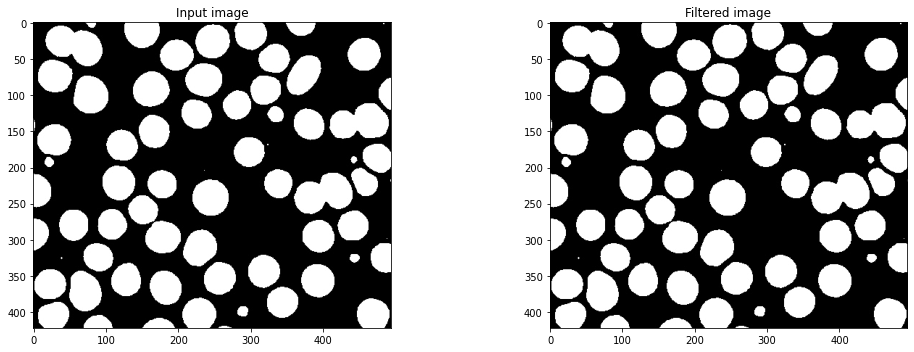

Number of cells: 56

hsv_c2.jpg


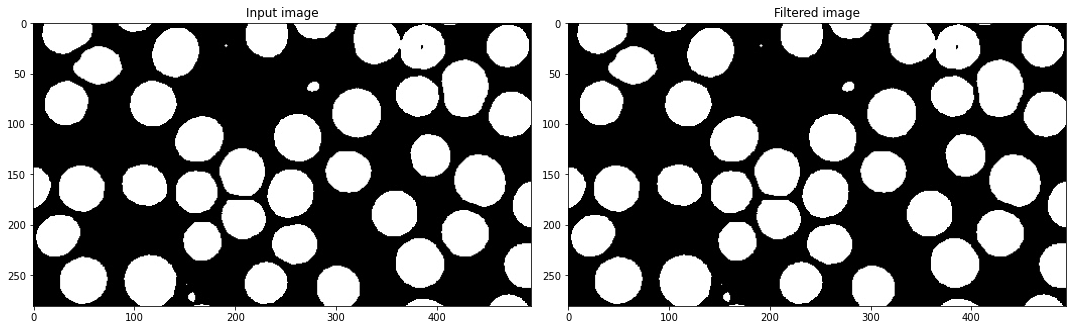

Number of cells: 37

hsv_c3.jpg


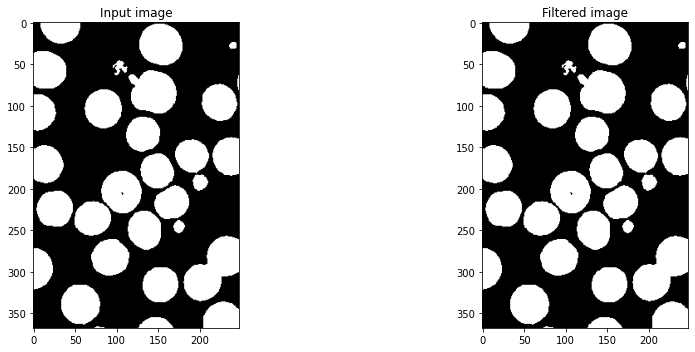

Number of cells: 27

hsv_c4.jpg


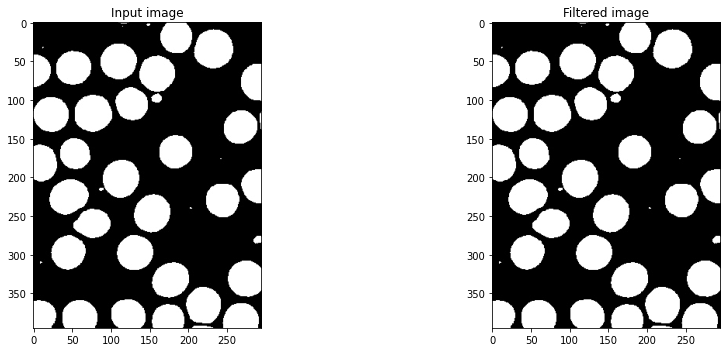

Number of cells: 30



In [8]:
def task2():
    for filename in os.listdir('out_images'):
        # binary image choice, can be changed to otsu
        if not filename.startswith('hsv'):
            continue
            
        print(filename)

        fig, ax = plt.subplots(1,2, figsize=(15,5))
        
        # show input image
        img = cv2.imread(f'out_images/{filename}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ax[0].imshow(img, 'gray')
        ax[0].set_title('Input image')
        
        # show filtered image
        filtered_img, num_cells = generate_image_and_count_cells(img)
        cv2.imwrite(f'out_images/filtered_{filename}', filtered_img)
        ax[1].imshow(img, 'gray')
        ax[1].set_title('Filtered image')
        
        plt.tight_layout()
        plt.show()
        print(f"Number of cells: {num_cells}\n")
        
task2()